<a href="https://colab.research.google.com/github/verg1lio/XangoER/blob/rascunho_Leonardo/Simula%C3%A7%C3%A3o_motor_gaiola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4188.098852701545


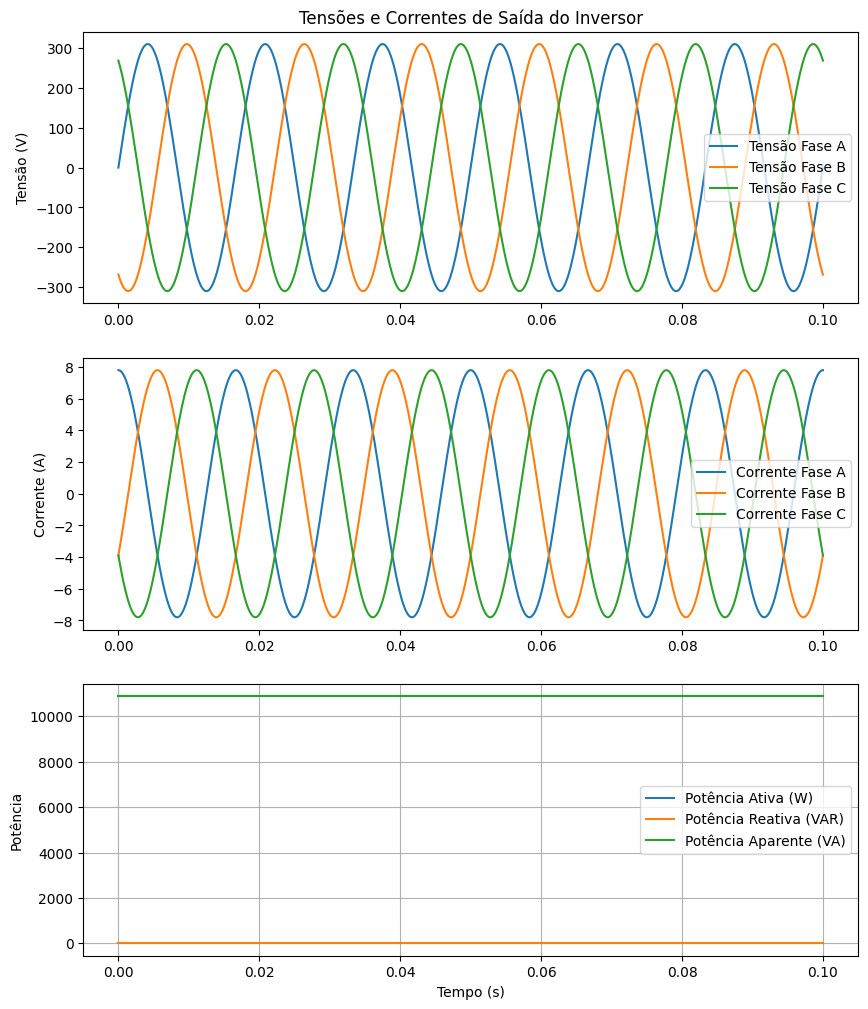

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class InversorWEGCFW300:
    def __init__(self, V_m, f, V_dc, i_dc, phi, theta, f_s, m):
        self.V_m = V_m  # Tensão de entrada RMS (V)
        self.f = f  # Frequência de entrada (Hz)
        self.V_dc = V_dc  # Tensão CC (V)
        self.i_dc = i_dc  # Corrente CC (A)
        self.phi = phi  # Ângulo de fase da tensão de entrada (rad)
        self.theta = theta  # Ângulo de fase da corrente de saída (rad)
        self.f_s = f_s  # Frequência de chaveamento (Hz)
        self.m = m  # Índice de modulação

        # Cálculo do período de chaveamento
        self.T_s = 1 / f_s

        # Cálculo do ângulo de modulação
        self.theta_m = np.arcsin(m)

        # Cálculo da frequência angular de entrada
        self.omega = 2 * np.pi * f

        # Cálculo da tensão de saída fundamental
        self.V_o1 = (2 * V_dc / np.pi) * m

    def gerar_tensoes_saida(self, t):
        u_a = self._gerar_funcao_comutacao(t, self.theta_m)
        u_b = self._gerar_funcao_comutacao(t, self.theta_m + 2 * np.pi / 3)
        u_c = self._gerar_funcao_comutacao(t, self.theta_m + 4 * np.pi / 3)

        v_sw_a = self.V_dc * u_a
        v_sw_b = self.V_dc * u_b
        v_sw_c = self.V_dc * u_c

        v_a = v_sw_a * np.sin(self.omega * t - self.phi)
        v_b = v_sw_b * np.sin(self.omega * t - self.phi - 2 * np.pi / 3)
        v_c = v_sw_c * np.sin(self.omega * t - self.phi + 2 * np.pi / 3)

        return v_a, v_b, v_c

    def gerar_correntes_saida(self, t):
        # Utilizando a mesma forma das tensões, por simplicidade
        i_a, i_b, i_c = self.gerar_tensoes_saida(t)
        i_a = self.i_dc * np.sin(self.omega * t - self.theta + np.pi/2)
        i_b = self.i_dc * np.sin(self.omega * t - self.theta - 2 * np.pi / 3 + np.pi/2)
        i_c = self.i_dc * np.sin(self.omega * t - self.theta + 2 * np.pi / 3 + np.pi/2)
        return i_a, i_b, i_c

    def calcular_potencias(self, v_a, v_b, v_c, i_a, i_b, i_c):
        V_ef = np.sqrt(np.mean(v_a**2 + v_b**2 + v_c**2))
        I_ef = np.sqrt(np.mean(i_a**2 + i_b**2 + i_c**2))
        P = 3 * V_ef * I_ef * np.cos(0)
        Q = np.mean(v_a * i_a * np.sin(self.phi)) + np.mean(v_b * i_b * np.sin(self.phi)) + np.mean(v_c * i_c * np.sin(self.phi))
        S = np.sqrt(P**2 + Q**2)
        return P, Q, S

    def _gerar_funcao_comutacao(self, t, theta_m):
        k = np.floor((t + self.T_s / 4) / self.T_s)
        u = (t < (k * self.T_s + theta_m)).astype(int)
        return u

# Parâmetros do inversor
V_m = 220
f = 60
V_dc = 310
i_dc = 7.8
phi = 0
theta = 0
f_s = 100
m = 0.01

t_sim = 0.1
t = np.linspace(0, t_sim, 1000)

inversor = InversorWEGCFW300(V_m, f, V_dc, i_dc, phi, theta, f_s, m)

v_a, v_b, v_c = inversor.gerar_tensoes_saida(t)
i_a, i_b, i_c = inversor.gerar_correntes_saida(t)
Pin= np.sqrt(3) * V_dc * i_dc * np.cos(0)
print(Pin)
Pa, Q, S = inversor.calcular_potencias(v_a, v_b, v_c, i_a, i_b, i_c)

plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.plot(t, v_a, label='Tensão Fase A')
plt.plot(t, v_b, label='Tensão Fase B')
plt.plot(t, v_c, label='Tensão Fase C')
plt.title('Tensões e Correntes de Saída do Inversor')
plt.ylabel('Tensão (V)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, i_a, label='Corrente Fase A')
plt.plot(t, i_b, label='Corrente Fase B')
plt.plot(t, i_c, label='Corrente Fase C')
plt.ylabel('Corrente (A)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, np.full_like(t, Pa), label='Potência Ativa (W)')
plt.plot(t, np.full_like(t, Q), label='Potência Reativa (VAR)')
plt.plot(t, np.full_like(t, S), label='Potência Aparente (VA)')
plt.xlabel('Tempo (s)')
plt.ylabel('Potência')
plt.legend()

plt.grid(True)
plt.show()


Escorregamento máximo e torque: s=0.10400000000000001, Torque=57.91376296719123 Nm
Velocidade Sincrona: 376.99111843077515 (rad/s) ou 3600.0RPM


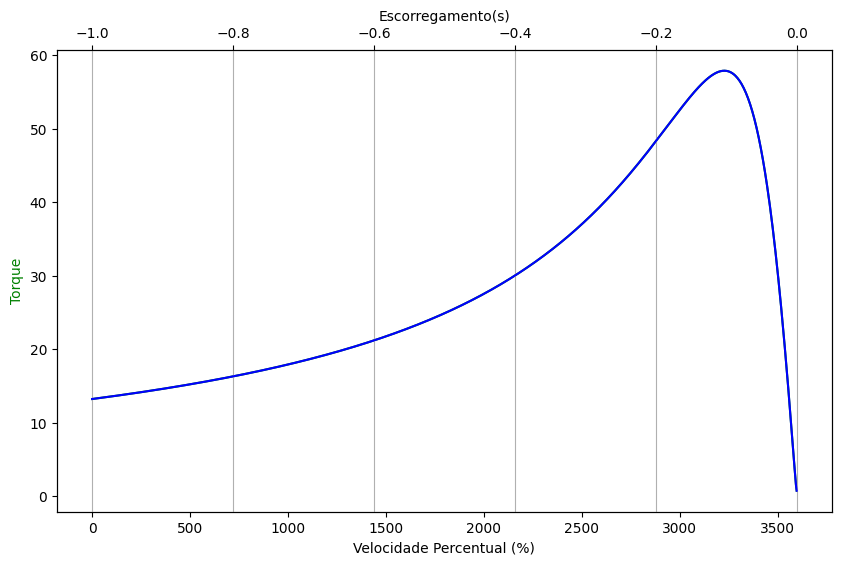

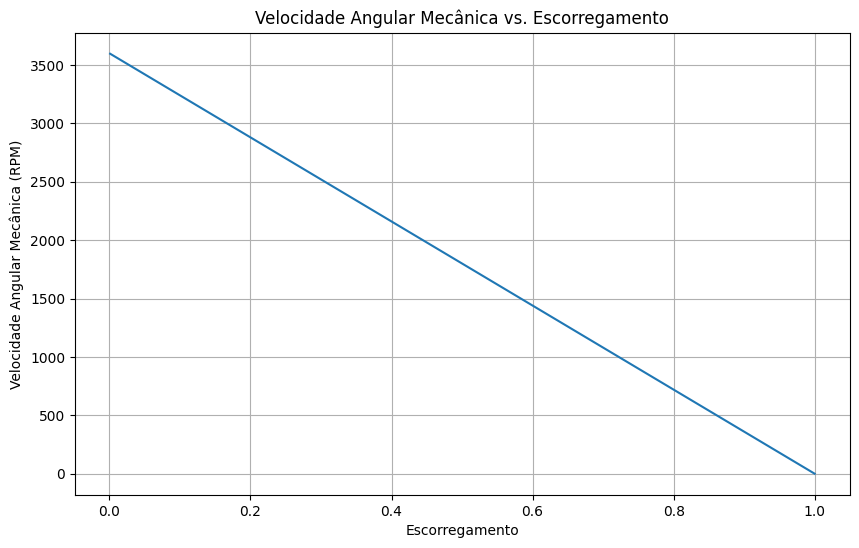

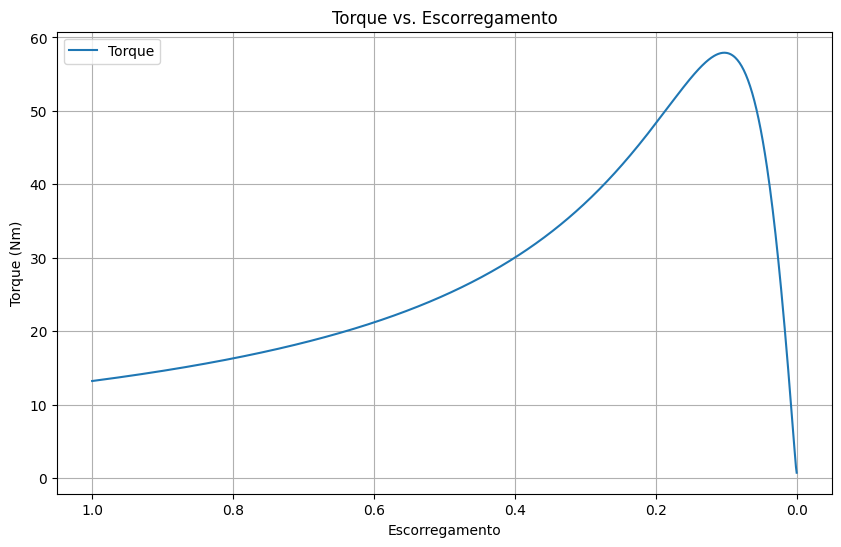

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



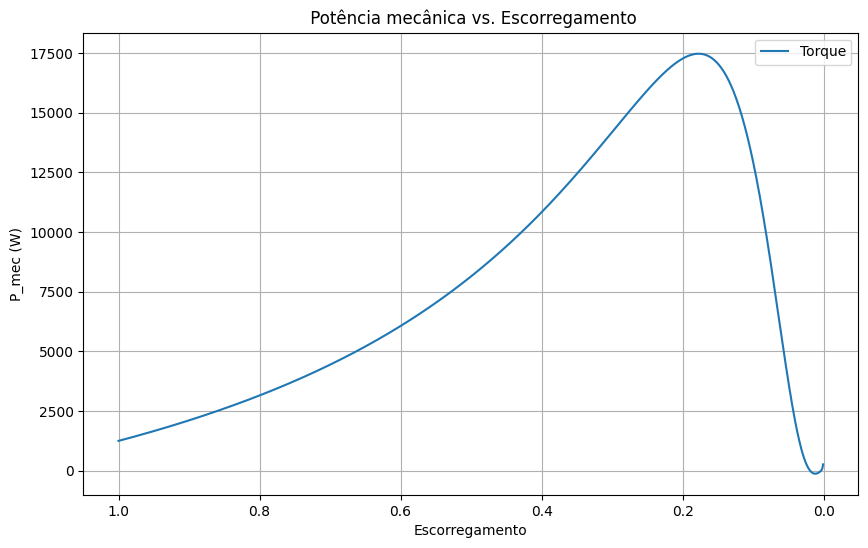

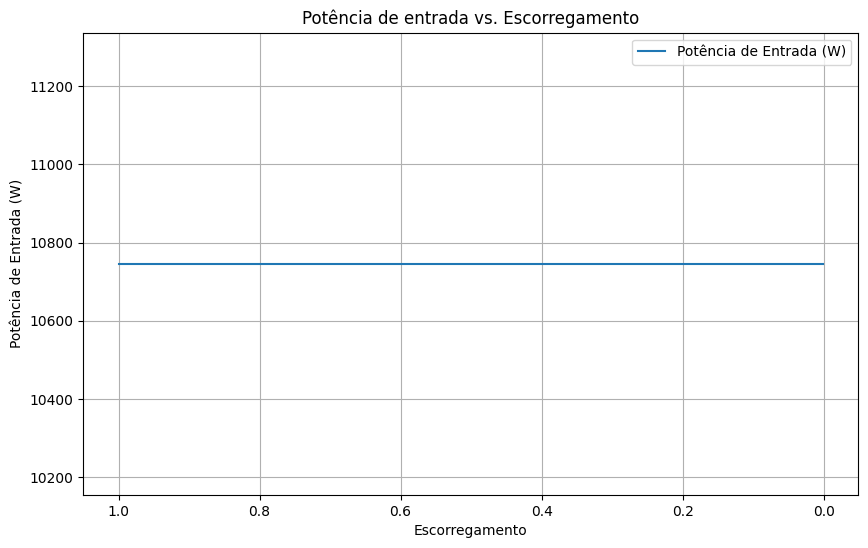

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cmath  # Para operações com números complexos

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)  # Velocidade síncrona

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 + Z2_prime, Z1, Z2 , Zm, Z2_prime

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[0]
        I_fase = V_fase / Z
        return I_fase

    def calcular_corrente1(self, V_fase, s):
        Z1 = self.calcular_impedancia(s)[1]
        I_fase1 = V_fase / Z1
        return I_fase1

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[1]
        return E2

    def calcular_corrente_de_partida(self, V_fase, s):
        Im = self.calcular_tensao_induzida(V_fase, s) / self.Xm
        I2 = self.calcular_corrente(V_fase, s) - Im
        return I2

    def calcular_potencia(self, V_fase, s):
        I_fase = self.calcular_corrente1(V_fase, s)
        P_fase = V_fase * I_fase * 1
        return 3*P_fase


    def calcular_torque(self, V_fase, s):

        # Corrente do rotor
        I2 = self.calcular_corrente_de_partida(V_fase, s)

        # Potência no rotor e torque
        P_r = 3 * abs(I2)**2 * (self.R2 / s)
        torque = P_r / self.w_s

        return self.K * torque  # Aplica a constante de proporcionalidade

    def calcular_perdas(self, s):
        I2= self.calcular_corrente_de_partida(220, s)
        perdaR = (I2**2) *self.calcular_impedancia(s)[4]
        return perdaR

    def encontrar_maior_torque(self, V_fase, escorregamentos):
        torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
        max_torque = max(torques)
        max_s = escorregamentos[torques.index(max_torque)]
        return max_s, max_torque

    def calcular_velocidade_angular(self, escorregamentos):
        return (self.w_s * (1 - escorregamentos)) * (30 / np.pi)

    def simular_desempenho(self, V_fase, escorregamentos):
        torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
        plt.figure(figsize=(10, 5))
        plt.plot(escorregamentos, torques, label='Torque (Nm)')
        plt.title('Torque vs. Escorregamento')
        plt.xlabel('Escorregamento')
        plt.ylabel('Torque (Nm)')
        plt.grid(True)
        plt.show()

# Exemplo de uso
frequencia = 60  # frequência em Hz
P = 2  # Número de polos
R1 = 0.135  # Resistência do estator
X1 = 0.768  # Reatância do estator
R2 = 0.0916  # Resistência do rotor
X2 = 0.123  # Reatância do rotor
Xm = 142.3  # Reatância magnética
K = 0.95  # Constante de proporcionalidade para o torque ajustada para exemplo

# Instanciação do motor
motor = MotorDeGaiola(frequencia, P, R1, X1, R2, X2, Xm, K)

# Tensão aplicada (exemplo)
V_fase = V_m / np.sqrt(3)  # Tensão de fase (V) a partir de uma tensão de linha de 220V

PotenciaA=MotorDeGaiola.calcular_potencia(motor,V_fase,1)

# Simular o desempenho do motor para uma faixa de escorregamentos
escorregamentos = np.linspace(0.001, 1, 1000)
torques = [motor.calcular_torque(V_fase, s) for s in escorregamentos]

# Encontrar maior torque
s_max, torque_max = motor.encontrar_maior_torque(V_fase, escorregamentos)

print(f"Escorregamento máximo e torque: s={s_max}, Torque={torque_max} Nm")
print(f"Velocidade Sincrona: {motor.w_s} (rad/s) ou {(motor.w_s)*30/np.pi}RPM")

# Calcular a velocidade percentual
velocidades_percentuais = (1 - escorregamentos) * ((motor.w_s)*30/np.pi)

esp=np.abs(-escorregamentos)

# Plotagem de Torque vs. Velocidade Percentual
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotar dados no primeiro eixo
ax1.plot(velocidades_percentuais,torques, 'g-')
ax1.set_xlabel('Velocidade Percentual (%)')
ax1.set_ylabel('Torque', color='g')
# Adicionar um segundo eixo x em cima
ax2 = ax1.twiny()
ax2.plot(-esp, torques, 'b-')
ax2.set_xlabel('Escorregamento(s)')
plt.grid(True)
plt.show()

print('\n')

# Calcular e plotar a velocidade angular mecânica vs. escorregamento
velocidades_angulares = motor.calcular_velocidade_angular(escorregamentos)
perdas=motor.calcular_perdas(escorregamentos)
P_mec=torques*(velocidades_angulares*(np.pi/30)) - perdas



plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, velocidades_angulares)
plt.title('Velocidade Angular Mecânica vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Velocidade Angular Mecânica (RPM)')
plt.grid(True)
plt.show()

print('\n')

# Plotagem de Torque vs. Escorregamento
plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, torques, label='Torque')
plt.title('Torque vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

# Plotagem de Torque vs. Escorregamento
plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, P_mec , label='Torque')
plt.title(' Potência mecânica vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('P_mec (W)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()


# Calcular potência para cada escorregamento
potencias = [motor.calcular_potencia(V_fase, s).real for s in escorregamentos]  # Parte real da potência

# Plotagem de Potência vs. Escorregamento
plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, potencias, label='Potência de Entrada (W)')
plt.title('Potência de entrada vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Potência de Entrada (W)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()


In [62]:
import numpy as np
import plotly.graph_objects as go

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)  # Velocidade síncrona

    def set_frequencia(self, frequencia):
        """Atualiza a frequência e recalcula a velocidade síncrona."""
        self.frequencia = frequencia
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 + Z2_prime

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)
        return V_fase / Z

    def calcular_torque(self, V_fase, s):
        I2 = abs(self.calcular_corrente(V_fase, s))
        P_r = 3 * I2**2 * (self.R2 / s)

        if self.frequencia <= 60:
            w_s_nominal = 2 * np.pi * 60 / (self.P / 2)
            return self.K * P_r / w_s_nominal
        else:
            return self.K * P_r / self.w_s

    def simular_malha(self, V_fase, escorregamentos, freq_min=1, freq_max=360, passo=60):
        """Gera uma malha de torque para uma faixa de frequências e escorregamentos."""
        frequencias = np.arange(freq_min, freq_max + 1, passo)
        escorregamentos = np.array(escorregamentos)
        torques = np.zeros((len(frequencias), len(escorregamentos)))

        for i, freq in enumerate(frequencias):
            self.set_frequencia(freq)
            torques[i, :] = [self.calcular_torque(V_fase, s) for s in escorregamentos]

        return frequencias, escorregamentos, torques

    def plotar_superficie_torque(self, V_fase, escorregamentos,Polos, freq_min=12, freq_max=120, passo=12):
        """Plota o gráfico de superfície interativo usando Plotly, com RPM e linhas para torque nominal e máximo."""
        # Simular a malha de torques
        frequencias, escorreg, torques = self.simular_malha(V_fase, escorregamentos, freq_min, freq_max, passo)

        # Converter frequências para RPM
        rpm = (120 * frequencias) / Polos  # Fórmula para RPM


        s_nominal = 0.02
        # Determinar o torque nominal (s = 0.07)
        idx_nominal = np.where(np.isclose(escorreg, s_nominal, atol=0.0001))[0]
        if len(idx_nominal) > 0:
            torque_nominal = torques[:, idx_nominal[0]]  # Coluna associada ao escorregamento nominal
        else:
            torque_nominal = None
            print(f"Escorregamento nominal ({s_nominal}) não encontrado na lista de escorregamentos.")


        # Determinar o torque máximo
        torques_maximos = [max(torques[i]) for i in range(len(frequencias))]
        s_maximos = [escorreg[torques[i].argmax()] for i in range(len(frequencias))]  # Escorregamento associado ao torque máximo

        # Calcular a potência para o torque nominal e máximo
        pn = [torque_nominal[i] * (2 * np.pi * frequencias[i] / (Polos/2)) for i in range(len(frequencias))]
        pmax = [torques_maximos[i] * (2 * np.pi * frequencias[i] / (Polos/2)) for i in range(len(frequencias))]  # Potência máxima


        # Criar o gráfico 3D
        fig = go.Figure()

        # Superfície 3D
        fig.add_trace(go.Surface(
            x=escorreg,  # Escorregamento no eixo X
            y=rpm,  # RPM no eixo Y
            z=torques,  # Torque no eixo Z
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="Torque (Nm)")
        ))

        # Adicionar linha para torque nominal (se encontrada)
        if torque_nominal is not None:
            fig.add_trace(go.Scatter3d(
                x=[s_nominal] * len(frequencias),  # Escorregamento fixo
                y=rpm,  # RPM
                z=torque_nominal,  # Torque nominal
                mode='lines',
                line=dict(color='red', width=4),
                name=f"Torque Nominal ({s_nominal})",
            ))


        # Adicionar linha para torque máximo
        fig.add_trace(go.Scatter3d(
            x=s_maximos,  # Escorregamentos associados ao torque máximo
            y=rpm,  # RPM
            z=torques_maximos,  # Torque máximo
            mode='lines',
            line=dict(color='blue', width=4),
            name="Torque Máximo"
        ))

        # Configurações do layout
        fig.update_layout(
            title="Superfície de Torque vs Escorregamento vs RPM",
            scene=dict(
                xaxis_title="Escorregamento",
                yaxis_title="RPM",
                zaxis_title="Torque (Nm)",
                yaxis=dict(autorange="reversed")  # Invertendo o eixo de frequência
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            margin=dict(l=0, r=0, b=0, t=40)
        )

        fig.show()

        # Criando o gráfico de potência com duas escalas
        fig1 = go.Figure()

        # Potência nominal
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=pn,
            mode='lines',
            line=dict(color='red', width=4),
            name=f"Potência Nominal (Pn)"
        ))

        # Potência máxima
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=pmax,
            mode='lines',
            line=dict(color='red', width=4, dash='dash'),
            name=f"Potência Máxima"
        ))
        #torque nominal
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=torque_nominal,
            mode='lines',
            line=dict(color='blue', width=4),
            name=f"Torque Nominal",
            yaxis='y2'
        ))
        #torque máximo
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=torques_maximos,
            mode='lines',
            line=dict(color='blue', width=4, dash='dash'),
            name=f"Torque Máximo",
            yaxis='y2'
        ))

        # Adicionando a segunda escala (para o torque)
        fig1.update_layout(
            title="Potência vs Torque",
            xaxis=dict(
                title="RPM",
                showgrid=False
            ),
            yaxis=dict(
                title="Potência (kW)",
                titlefont=dict(color='red'),
                tickfont=dict(color='red'),
                side='left'
            ),
            yaxis2=dict(
                title="Torque (Nm)",
                titlefont=dict(color='blue'),
                tickfont=dict(color='blue'),
                overlaying='y',
                side='right'
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            margin=dict(l=0, r=0, b=0, t=40)
        )

        fig1.show()




# Parâmetros iniciais do motor
frequencia = 60  # Frequência inicial em Hz
P = 2  # Número de polos
R1 = 0.135  # Resistência do estator
X1 = 0.768  # Reatância do estator
R2 = 0.0916  # Resistência do rotor
X2 = 0.123  # Reatância do rotor
Xm = 142.3  # Reatância magnética
K = 1  # Constante de proporcionalidade

motor = MotorDeGaiola(frequencia, P, R1, X1, R2, X2, Xm, K)

# Simulação
V_fase = 220 / np.sqrt(3)  # Tensão de fase
escorregamentos = np.linspace(0.01, 1, 100)  # Escorregamento de 1% a 100%

motor.plotar_superficie_torque(V_fase, escorregamentos,P, freq_min=12, freq_max=120, passo=12)
